In [1]:
from rpy2 import robjects
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import multiprocessing as mp
import pandas as pd
import numpy as np
import datetime
import yaml
import os
# Convert pandas dataframe
from rpy2.robjects import pandas2ri
pandas2ri.activate()
# Suppress R warnings in python:
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

output_dir = 'output_14-21-newdata/'

dept_avail = os.listdir(output_dir)

rainfall = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)
cases    = pd.read_csv('haiti-data/fromAzman/cases_corrected.csv', index_col=0, parse_dates =True)
rain     = pd.read_csv('haiti-data/proj/rainfall.csv', index_col = 0, parse_dates = True)

compartments = ['S', 'I', 'A', 'RA1', 'RA2', 'RA3', 'RI1', 'RI2', 'RI3', 'W', 'B', 'cases', 'C',
                 "VSd", "VRI1d", "VRI2d", "VRI3d", "VRA1d", "VRA2d", "VRA3d",
                 "VSdd", "VRI1dd", "VRI2dd", "VRI3dd", "VRA1dd", "VRA2dd", "VRA3dd",
                 "VSd_alt", "VRI1d_alt", "VRI2d_alt", "VRI3d_alt", "VRA1d_alt", "VRA2d_alt", "VRA3d_alt",
                 "VSdd_alt", "VRI1dd_alt", "VRI2dd_alt", "VRI3dd_alt", "VRA1dd_alt", "VRA2dd_alt", "VRA3dd_alt"]

stream = open('haiti-data/input_parameters.yaml', 'r')
input_parameters = yaml.load(stream)

dept_name = [list(pop.keys())[0] for pop in input_parameters['population']]

t_start = input_parameters['t_start']
t_for = datetime.date(2029,12,20)

index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')

nsim = 1000
run_lvl = 3
n_proc = 8

In [30]:
def make_genuine_mobility_file():
    covar_init = pd.concat([cases[t_start:]]*6, ignore_index=True)[0:-506]
    covar_init.index = pd.DatetimeIndex(start =  datetime.date(2010,10,23), 
                                      end = t_for, freq = 'W-SAT')
    covar_init.to_csv('covar_mob.csv', index_label='date')
    return covar_init

In [2]:
class VaccinationScenario():
    def __init__(self, course_year, percent_completely_unvaccinated, percent_onedose, percent_twodoses, not_dep = []):
        pop = {'Artibonite':1727524,
        'Centre':746236,
        'Grande_Anse':468301,
        'Nippes':342525,
        'Nord':1067177,
        'Nord-Est':393967,
        'Nord-Ouest':728807,
        'Ouest':4029705,
        'Sud':774976,
        'Sud-Est':632601}
        ocv_order = ['Centre', 'Artibonite','Ouest','Nord-Ouest','Nord','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse']
        self.t_vacc_start = {}
        self.t_vacc_end = {}
        self.p1d_reg = {}
        self.r_v_year = {}

        #20% completely unvaccinated, 10% one-dose only, 70% two doses
        t_init = datetime.date(2019,1,12)
        days_per_departement = int((course_year*365)/len(ocv_order))

        for i, dp in enumerate(ocv_order):
            if dp not in not_dep:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = percent_onedose/(percent_onedose + percent_twodoses)
                self.r_v_year[dp] = pop[dp]*(100-percent_completely_unvaccinated)/100/days_per_departement * 365.25

            else:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = 0
                self.r_v_year[dp] =0


S0 = VaccinationScenario(1, 100, 0.1, 0.1, not_dep = dept_avail)
S1 = VaccinationScenario(2, 20, 10, 70)
S2 = VaccinationScenario(2, 20, 10, 70, not_dep=['Ouest','Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse'])
S3 = VaccinationScenario(5, 20, 10, 70)
S4 = VaccinationScenario(2, 3.33, 1.67, 95) #TODO give scenario correct names
S5 = VaccinationScenario(2, 3.33, 1.67, 95, not_dep=['Ouest','Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse'])
S6 = VaccinationScenario(5, 3.33, 1.67, 95)


In [3]:
def run_sim(dp):
    # see second answer of https://stackoverflow.com/questions/25175530/can-rpy2-code-be-run-in-parallel on why it starts different 
    # R instances
    r_source = robjects.r['source'];
    dept_data = {}
    r_options = robjects.r['options']
    r_options(warn=-1)
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('run_level <- ' + str(run_lvl))
    robjects.r('nsim <- ' + str(nsim))
    robjects.r('t_vacc_start <- "' + str(scenario.t_vacc_start[dp]) + '"')
    robjects.r('t_vacc_end  <- "' +  str(scenario.t_vacc_end[dp]) + '"')
    robjects.r('p1d_reg <- ' +       str(scenario.p1d_reg[dp]))
    robjects.r('r_v_year <- ' +      str(scenario.r_v_year[dp]))
    robjects.r('cases_ext <- 1')
    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV_mob.R')
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    return (dp, dept_data, robjects.r['params'], robjects.r('names(params)'))
    

#### Forecasting with no vaccination

In [24]:
all_data = {}
pars_dic = {}

scenario = S0
scenario_str = 'S0'
make_genuine_mobility_file()
with mp.Pool(processes=n_proc) as pool:
    for dp, dept_data, params, params_name in pool.imap_unordered(run_sim, dept_avail):
        all_data[dp] = dept_data
        pars_dic[dp] = params
        params_name = params_name
        
all_params = pd.DataFrame(0, columns = params_name, index= dept_avail)
for key, value in pars_dic.items():
    all_params.loc[key] = value        
        
# Convert years in mean duration of days day
rates = [ "gammaI", "gammaA", "rhoA", 'rhoI', 'mu_B']
params_disp = all_params.copy()
params_disp.loc[:,'rhoI'] = params_disp.loc[:,'XrhoI'] * params_disp.loc[:,'rhoA']
params_disp.loc[:,'thetaA'] = params_disp.loc[:,'XthetaA'] * params_disp.loc[:,'thetaI']
params_disp.drop(['mu', 'alpha', 'XrhoI', 'XthetaA', 't_vacc_start', 't_vacc_end', 'p1d_reg', 'r_v_year', 'H', 'D', 'Rtot_0'], axis =1, inplace = True)
print(params_disp)
for p in rates:
    params_disp.loc[:,p] =  1/(params_disp.loc[:,p]/365.25)
    
params_disp = params_disp.reindex(columns=sorted(params_disp.columns));

/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


                sigma     betaB        mu_B    thetaI    lambdaR         r  \
Artibonite   0.949817  0.128705  250.237116  0.000628   0.513733  0.724918   
Grande_Anse  0.686002  0.596252  108.847383  0.000610  13.769998  1.651420   
Centre       0.948488  0.989110  390.310061  0.000458   0.444297  0.950843   

              gammaI   gammaA      rhoA       foi_add   epsilon           k  \
Artibonite   182.625  182.625  0.125086  4.657182e-07  0.693990  185.993303   
Grande_Anse  182.625  182.625  0.125086  4.823893e-07  0.242668   47.105877   
Centre       182.625  182.625  0.125086  2.059946e-06  0.888860  281.023181   

                std_W  cases_ext      rhoI    thetaA  
Artibonite   0.007117        1.0  0.125086  0.000011  
Grande_Anse  0.048261        1.0  0.125086  0.000185  
Centre       0.003775        1.0  0.125086  0.000055  


### Extracting best performing parameters

In [5]:
params_disp

,betaB,cases_ext,epsilon,foi_add,gammaA,gammaI,k,lambdaR,mu_B,r,rhoA,rhoI,sigma,std_W,thetaA,thetaI
Artibonite,0.128705,1.0,0.693990,4.657182e-07,2.0,2.0,185.993303,0.513733,1.459616,0.724918,2920.0,2920.0,0.949817,0.007117,0.000011,0.000628
Grande_Anse,0.596252,1.0,0.242668,4.823893e-07,2.0,2.0,47.105877,13.769998,3.355616,1.651420,2920.0,2920.0,0.686002,0.048261,0.000185,0.000610
Centre,0.989110,1.0,0.888860,2.059946e-06,2.0,2.0,281.023181,0.444297,0.935794,0.950843,2920.0,2920.0,0.948488,0.003775,0.000055,0.000458


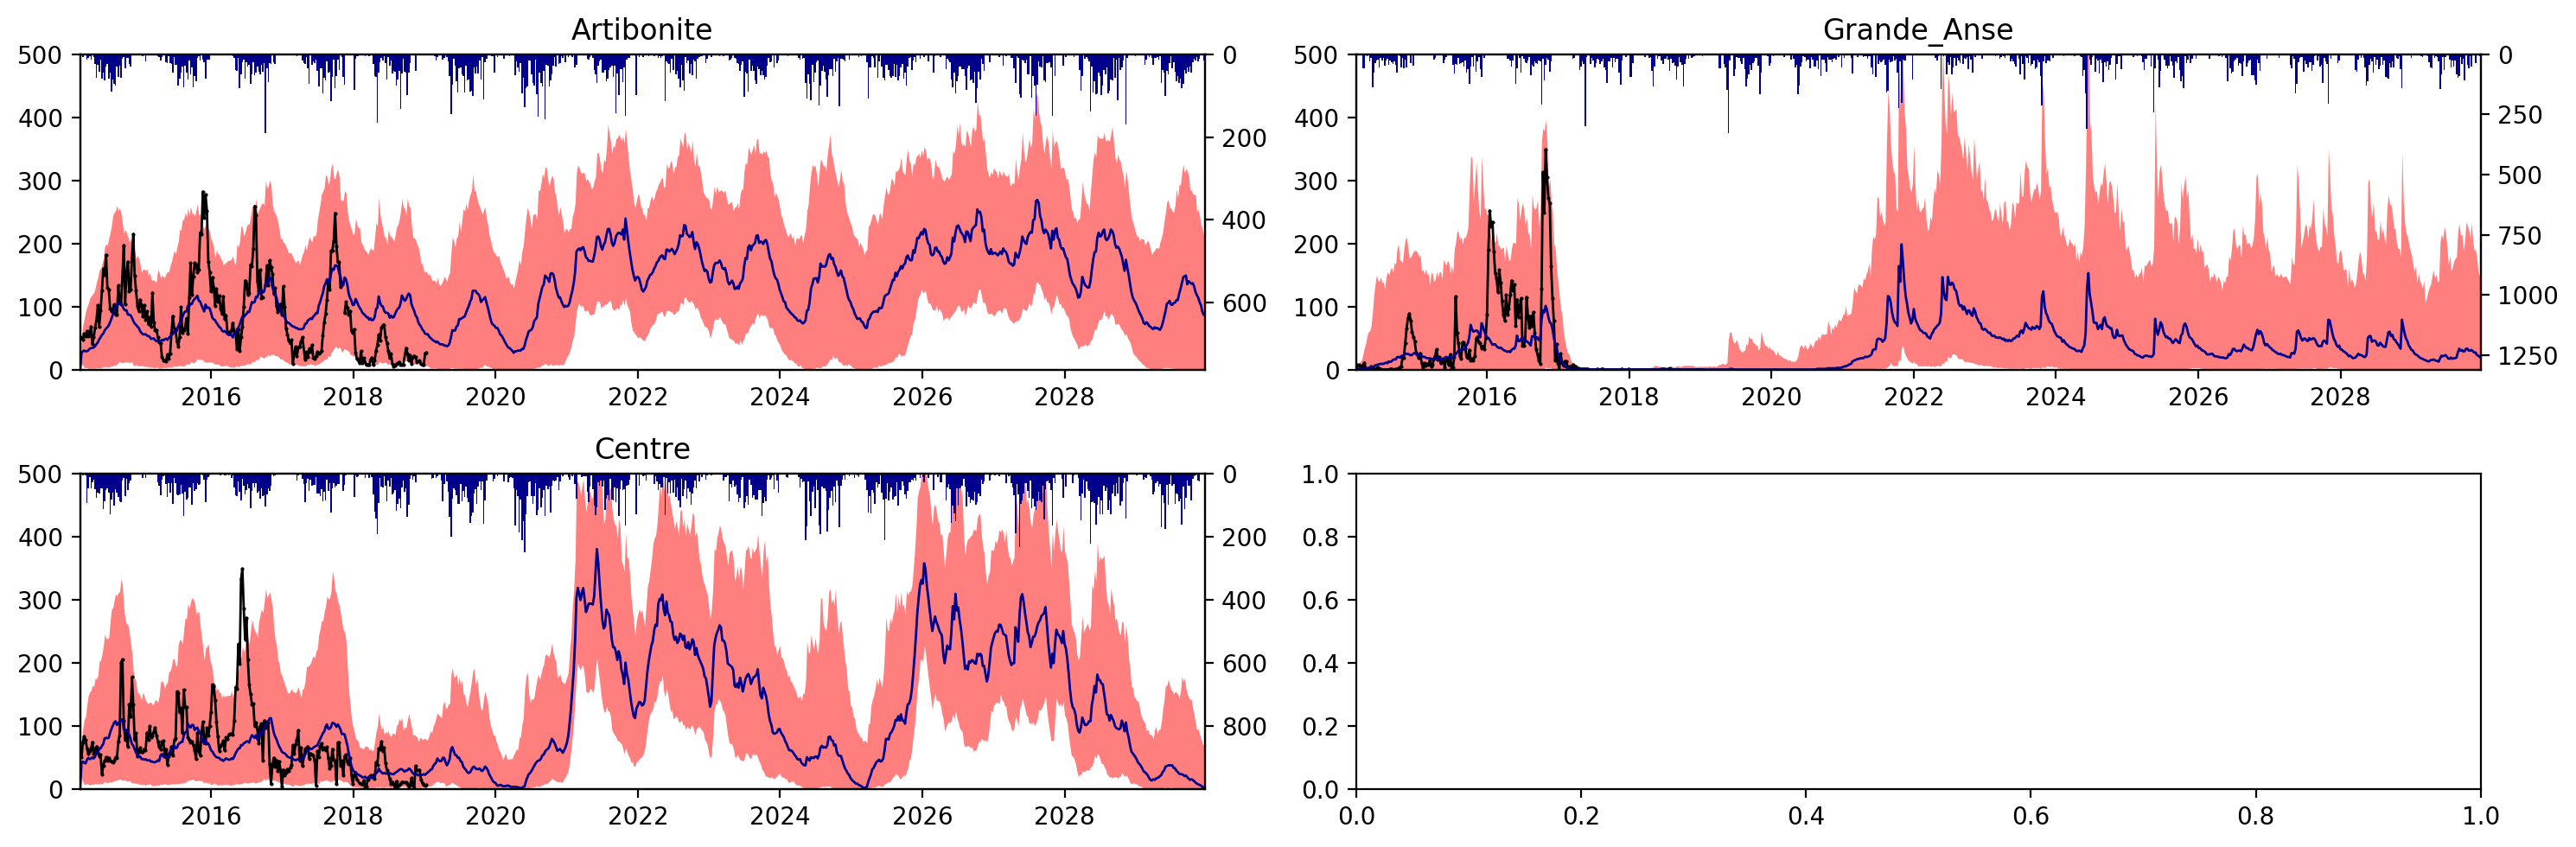

In [25]:
ti = input_parameters['t_start']
tf = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(dept_avail))//2+1, 2, figsize=(15,5), squeeze = True, dpi = 200);
fig.patch.set_facecolor('white')
axes = axes.flatten();
for i, dp in enumerate(dept_avail):

    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:][ti:tf], marker='.', linestyle='-',color='k', linewidth=1, markersize=1 ) 
    axes[i].fill_between(all_data[dp]['cases']['q05'][ti:tf].index, all_data[dp]['cases']['q05'][ti:tf], all_data[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(ti,tf, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[ti:tf], label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0, 500)
    axt.set_ylim(4*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)
    #axes[i].legend()
    
fig.tight_layout()

### Repartition in the differents compartiments for one departement 

In [ ]:
dp = 'Grande_Anse'
fig, axes = plt.subplots((len(compartments))//4+1, 4, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data[dp][comp]['q05'].index, all_data[dp][comp]['q05'], all_data[dp][comp]['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp][comp]['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp][comp]['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    axes[i].legend()
    axes[i].set_ylim(0)
    
fig.tight_layout()

#### Vaccination scenario

In [26]:
scenario = S4
scenario_str = 'S4'

### Vaccination without mobility to build the mobility file

In [63]:
all_data_vacc = {}

make_genuine_mobility_file()
with mp.Pool(processes=n_proc) as pool:
    for dp, dept_data, _, _ in pool.imap_unordered(run_sim, dept_avail):
        all_data_vacc[dp] = dept_data

/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


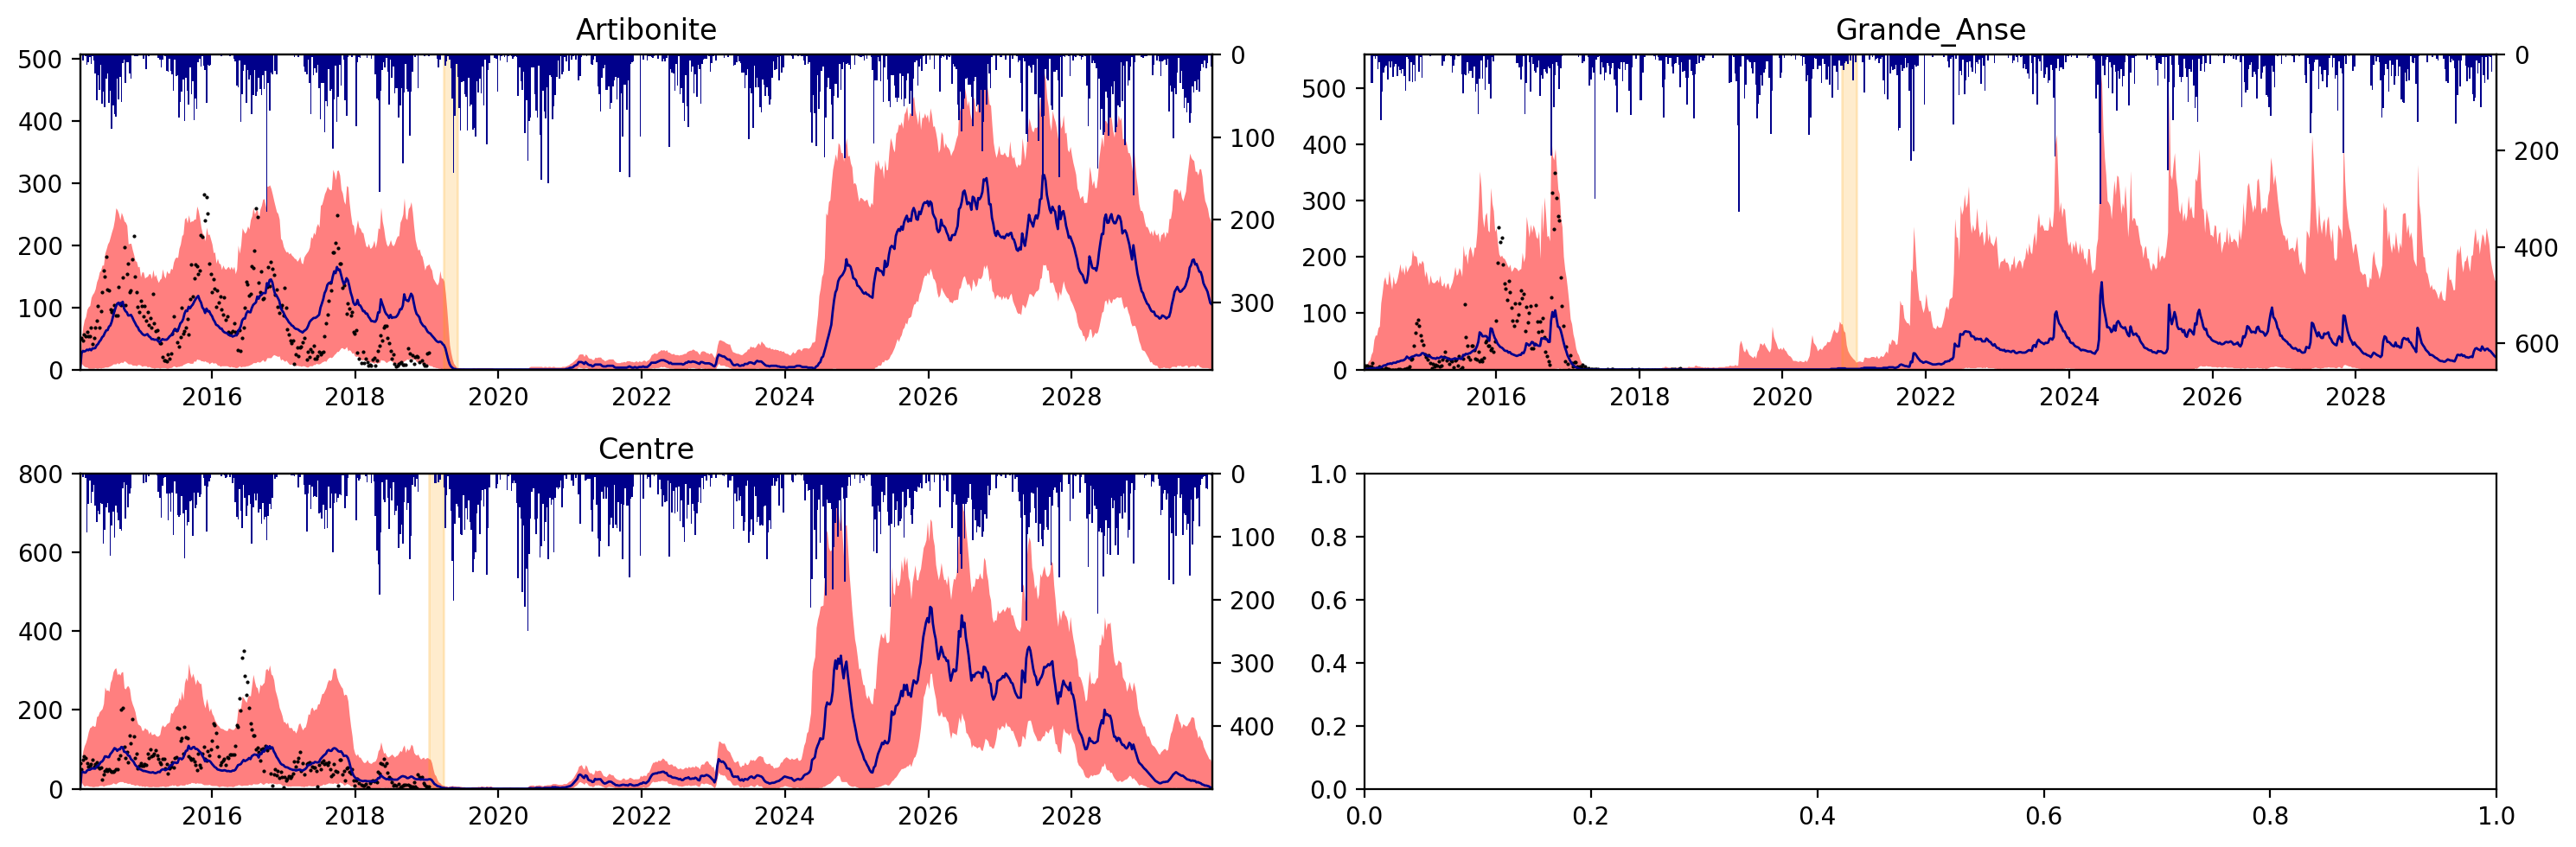

In [52]:
ti = input_parameters['t_start']
#ti = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(all_data))//2+1, 2, figsize=(15,5), squeeze = True, dpi = 200);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    
    axes[i].fill_between(all_data_vacc[dp]['cases']['q05'][ti:tf].index, all_data_vacc[dp]['cases']['q05'][ti:tf], all_data_vacc[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)    
    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5
    #axes[i].annotate(r'Vaccination', (cx, cy), color='black',# weight='bold', 
    #            fontsize=12, ha='center', va='center', rotation='vertical')

fig.tight_layout()

In [51]:
input_parameters['t_start']

datetime.date(2014, 3, 1)

#### Take away mobility to make a mobility file

In [59]:
vacc_init = pd.DataFrame(np.nan, pd.DatetimeIndex(start =  datetime.date(2010,10,23), 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

cases_df =  pd.DataFrame(np.nan, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

covar_mob_novacc = make_genuine_mobility_file()

for dp in dept_avail:
    cases_df[dp] = all_data_vacc[dp]['cases']['q50'][scenario.t_vacc_start[dp]+datetime.timedelta(days = 90) : scenario.t_vacc_start[dp] + datetime.timedelta(days = 200)]

for dp in dept_name:
    if dp in dept_avail:
        vacc_init[dp] = covar_mob_novacc[dp][datetime.date(2010,10,23):scenario.t_vacc_start[dp]]   # 
        vacc_init[dp].fillna(cases_df[dp].mean(), inplace = True)
        print(dp, cases_df[dp].mean())
    else:
        vacc_init[dp] = covar_mob_novacc[dp]  #0
    
vacc_init.to_csv('vacc_init' + scenario_str +  '.csv', index_label='date')

Artibonite 0.0
Centre 0.625
Grande_Anse 2.5


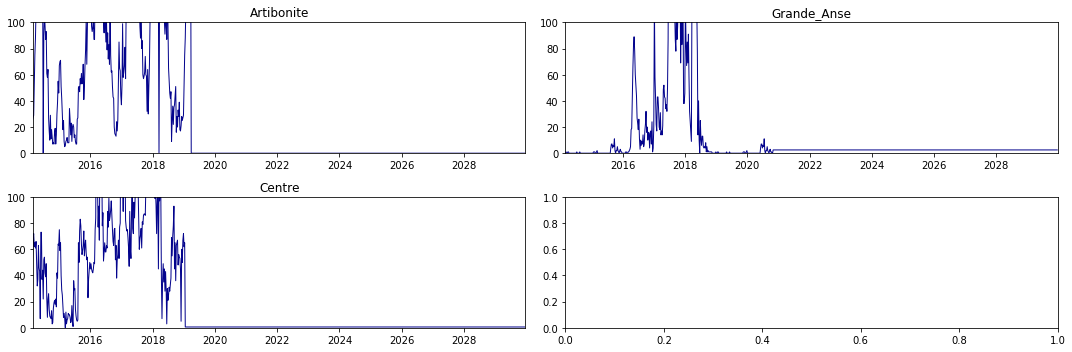

In [38]:
fig, axes = plt.subplots((len(all_data))//2+1, 2, figsize=(15,5), squeeze = True);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axes[i].plot(vacc_init[dp], alpha = 5,linestyle='-', linewidth = 1, color = 'darkblue')
    #axes[i].plot(covar_init[dp], alpha = 1,linestyle='-', linewidth = 1, color = 'red')
    axes[i].set_title(dp)
    axes[i].set_ylim(0,100)
    axes[i].set_xlim(t_start, t_for)

fig.tight_layout()

### Projection with mobility

In [65]:
vacc_init = pd.read_csv('vacc_init' + scenario_str +  '.csv', index_col = 0, parse_dates = True)
vacc_init.to_csv('covar_mob.csv', index_label='date')

all_data_vacc_mob = {}

with mp.Pool(processes=n_proc) as pool:
    for dp, dept_data, _, _ in pool.imap_unordered(run_sim, dept_avail):
        all_data_vacc_mob[dp] = dept_data


/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


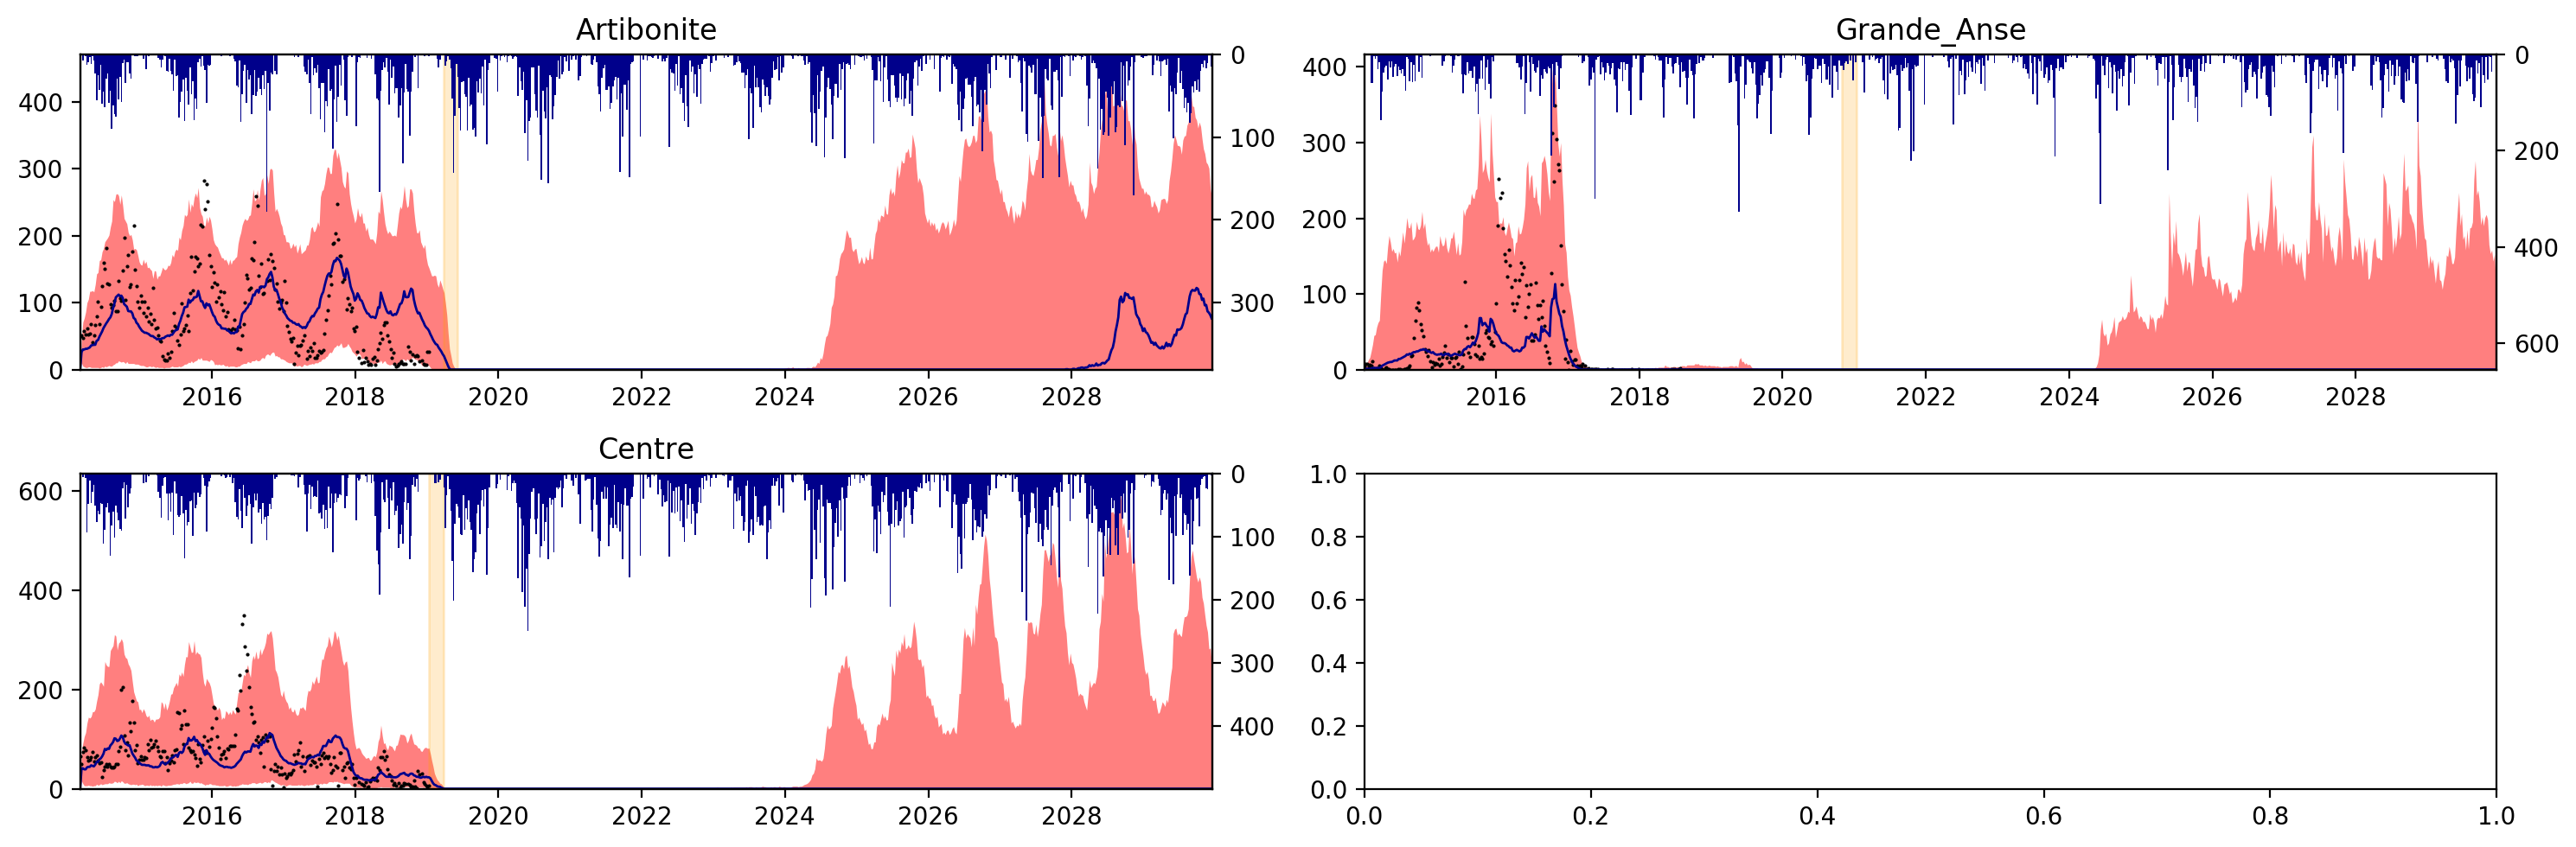

In [66]:
ti = input_parameters['t_start']
#ti = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(all_data))//2+1, 2, figsize=(15,5), squeeze = True, dpi = 200);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data_vacc_mob[dp]['cases']['q05'][ti:tf].index, all_data_vacc_mob[dp]['cases']['q05'][ti:tf], all_data_vacc_mob[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc_mob[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)    
    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5
    #axes[i].annotate(r'Vaccination', (cx, cy), color='black',# weight='bold', 
    #            fontsize=12, ha='center', va='center', rotation='vertical')

fig.tight_layout()

#### Comparison

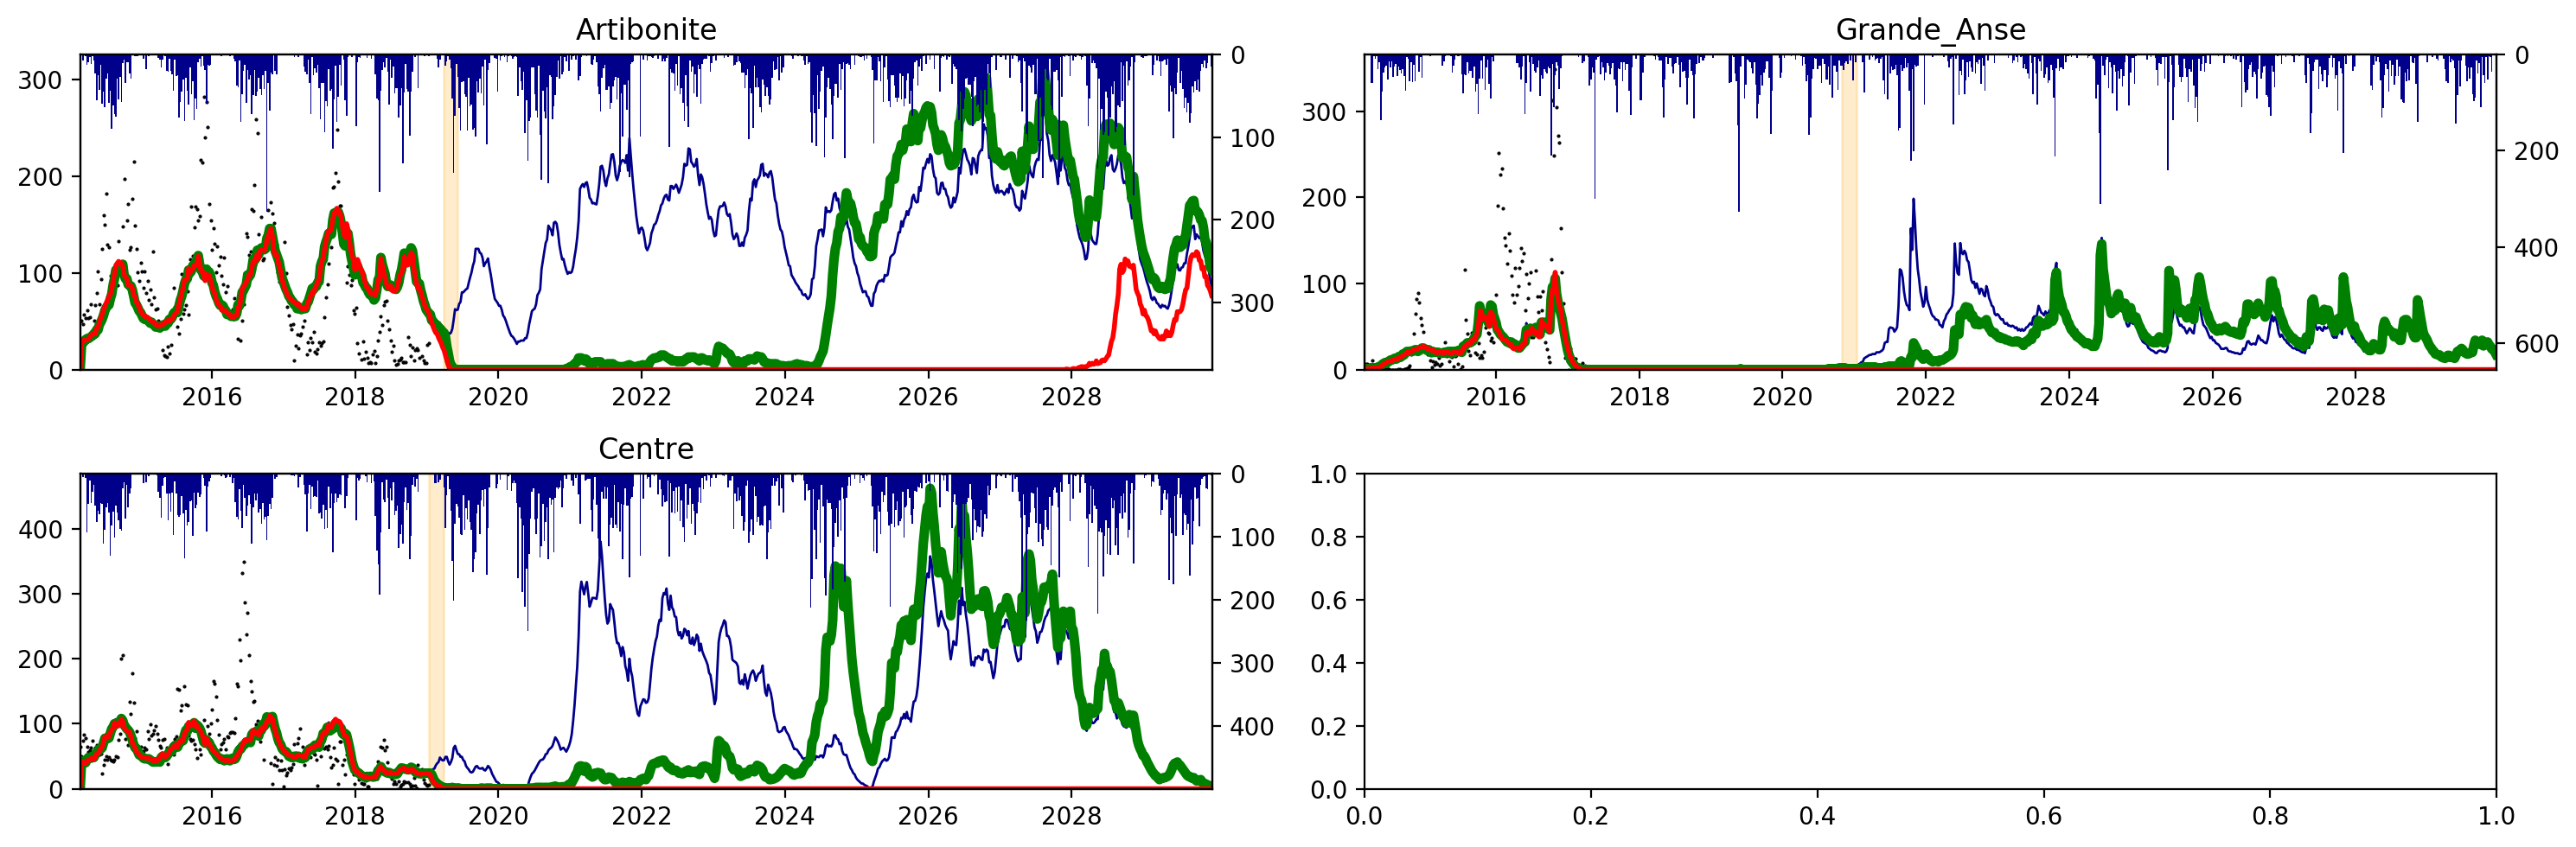

In [67]:
ti = input_parameters['t_start']
#ti = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(all_data))//2+1, 2, figsize=(15,5), squeeze = True, dpi = 200);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 )
    
    axes[i].plot(all_data[dp]['cases']['q50'][ti:tf],          alpha = 1, linestyle='-', linewidth = 1, color = 'darkblue')
    axes[i].plot(all_data_vacc[dp]['cases']['q50'][ti:tf],     alpha = 1, linestyle='-', linewidth = 4, color = 'green')
    axes[i].plot(all_data_vacc_mob[dp]['cases']['q50'][ti:tf], alpha = 1, linestyle='-', linewidth = 2, color = 'red')
    
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)    
    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5

fig.tight_layout()

### Save results !

In [ ]:
to_save = all_data_vacc
#scenario_str = 'S0'
csv_all_q50 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

csv_all_q05 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

csv_all_q95 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)


for dp in dept_avail:
        csv_all_q50[dp] = to_save[dp]['cases']['q50']
        csv_all_q95[dp] = to_save[dp]['cases']['q95']
        csv_all_q05[dp] = to_save[dp]['cases']['q05']
        
csv_all_q05.to_csv(scenario_str + '_q05.csv', index_label='date')
csv_all_q95.to_csv(scenario_str + '_q95.csv', index_label='date')
csv_all_q50.to_csv(scenario_str + '_q50.csv', index_label='date')
pd.concat([csv_all_q05.sum(axis=1), csv_all_q50.sum(axis=1), csv_all_q95.sum(axis=1)], axis = 1, keys = ['q05', 'q50', 'q95']).to_csv(scenario_str + '_national.csv', index_label='date')

for dp in dept_avail:
        csv_all_q50[dp] = to_save[dp]['C']['q50']
        csv_all_q95[dp] = to_save[dp]['C']['q95']
        csv_all_q05[dp] = to_save[dp]['C']['q05']
        
csv_all_q05.to_csv(scenario_str + '_q05_s.csv', index_label='date')
csv_all_q95.to_csv(scenario_str + '_q95_s.csv', index_label='date')
csv_all_q50.to_csv(scenario_str + '_q50_s.csv', index_label='date')
pd.concat([csv_all_q05.sum(axis=1), csv_all_q50.sum(axis=1), csv_all_q95.sum(axis=1)], axis = 1, keys = ['q05', 'q50', 'q95']).to_csv(scenario_str + '_national_s.csv', index_label='date')

### Elimination probability (deprecated)

In [366]:
sc = 'S6'
sims = pd.read_csv('all_sim' + sc +  '.csv', index_col = 0, parse_dates = True)
t_init = datetime.date(2018,7,14)
#1100 cases per year
#1.1 cases

pc_them = 0
pc_us = 0
for i in range(10):
    smlr = sims[str(i)][t_init:datetime.date(2022,12,31)].rolling(52).sum()
    if smlr.min() < 1100:
        pc_them += 10
    if smlr.min() < 1.1:
        pc_us += 10

        
# S1: 100 and 0
# S2: 0 and 0
# S3: 0 0
# S4 100 and 0
# S5 0 and 0
# S6 0 and 0
print(pc_them, pc_us)

0 0
